# ASSIGNMENT 2                                                McGill:COMP766-2 - Winter 2021 
Instructor: Siamak Ravanbakhsh
Student: McGill ID (PLEASE DO NOT INCLUDE YOUR NAME as we want to have anonymous grading)

The objective is to get familiar with exact inference methods. We do this in the context of binary valued MRF with pairwise interactions. In particular, we assume representation in the form of Ising model.

#### Ising model
The inference procedures below are specific to an Ising model that is fully expressed using
a symmetric adjacency matrix $A$ (```adj```):
\begin{align}
  p(x) = \frac{1}{Z} \exp(\sum_{i} A_{i,i}x_i + \sum_{i,j < i} x_iA_{i,j}x_j) \quad x_i \in \{-1,+1\}
\end{align}

In words, the diagonal of $A$ represents the local field and interactions are captured by the remaining non-zero elements of $A$.
The graph structure can also be inferred from the sparsity patter of $A$.
Here, we are interested in deterministic sum-product inference.


## Problem 1.   (10pts)

#### Base inference class 
 Class  ```Inference``` contains the base class for inference. All the following inference classes override the
  ```get_marginal()``` and ```update_adjacency()``` method of this class.
  The adjacency matrix ```adj``` representing the model, and the verbosity level are the two
  attributes initialized in this class.

 
### 1.a. (8 pts.)
We saw how to condition on an observation in a Bayes-net in the first assignment. Here, we do the same for our Ising model. Your first task is to implement the ```incorporate_evidence()``` method which updates the adjacency matrix to reflect an observation. Note that for simplicity of the follow-up task, we want this implementation to maintain the size of the adjacency matrix, and order of the nodes, and simply change the values inside the ```adj``` matrix. This is not the most principled way of conditioning, as in the general case we can remove the observed RVs from the MRF. Your implementation can use a _large_ factor to ensure $p(X_e = {x}_e) \approx 1$.

In [1]:
%matplotlib inline
LARGE_NUMBER = 100
import numpy as np
import matplotlib.pylab as plt
from utils import tensor_mult, draw_graph
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
import networkx as nx
np.random.seed(12345)
import timeit
#removing some warnings!
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

class Inference():
    """
        superclass of inference procedures for an Ising model.
        the model is represented using an adjacency matrix adj: 
        n x n symmetric adjacency matrix, the diagonal elements are the local potentials: 
        p(x) \propto exp(+\sum_{i,j<i} x_i x_j adj[i,j] + \sum_{i} x_i adj[i,i]) for  x_i \in {-1,+1}
    """

    def __init__(self, adj,
                 verbosity=1  # for more info, use higher verbosity level
    ):
        assert np.all(adj == np.transpose(
            adj)), "the adjacency matrix is not symmetric"
        self.adj = adj
        self._verbosity = verbosity

    def get_marginal(
            target=None
    ):
        """
        return the marginal prob. of xi = 1
        for the list of target variables
        --i.e., a vector of marginals p(xi=1)
        """
        pass
    
    def update_adjacency(self, new_adj):
        self.adj = new_adj

    def incorporate_evidence(self, e):
        """ 
        evidence is a dictionary of assignments to a subset of variables; 
        for example e = {0:+1, 2:-1, 6:-1} means x0 <- 1, x2 <- -1 and x6 <- -1
        this method updates the adjacency matrix to incorporate evidence
        """
        # >>>> YOUR CODE HERE >>>>>>>

        # >>>> YOUR CODE HERE >>>>>>>
        self.update_adjacency(new_adj) #new_adj[np.ix_(keep, keep)])
        

#### Brute force inference
The following class implements brute-force inference, where we explicitly construct the high-dimensional array of the joint distribution. This code in its complete form is provided for you, because you have implemented a similar procedure in the first assignment.
 You can reliably debug your following implementation for more efficient exact inference using  ```BruteForceInference```. 
  It is instructive to go through this code and understand it. Use the ```verbosity``` parameter, during initialization to control the amount of output produced during inference for each inference procedure.

In [2]:
class BruteForceInference(Inference):
    """
    represents bruete-force inference by
    producing the high-dimensional joint array
    """
    def __init__(self, adj, verbosity=1):
        Inference.__init__(self, adj, verbosity)
        self.joint = self._get_joint()
        
    def _get_joint(self):
        """
        builds the n-dim array of the joint (size 2 x 2 x ... x 2)
        returns the joint probability array that has n-dimensions
        """
        adj = self.adj
        n = adj.shape[0]
        if self._verbosity > 0:
            print("producing the joint dist over %d variables" % (n), flush=True)
        pairwise = np.zeros([2, 2])
        local = np.zeros([2])
        joint = np.ones(n*[2], dtype=np.float)
        for i, j in np.transpose(np.nonzero(adj)):
            if i < j:
                pairwise[0, 0] = np.exp(adj[i, j])
                pairwise[1, 1] = pairwise[0, 0]
                pairwise[0, 1] = np.exp(-adj[i, j])
                pairwise[1, 0] = pairwise[0, 1]
                joint = tensor_mult(joint, pairwise, [i, j], [0, 1])
            elif i == j:
                local[0] = np.exp(-adj[i, j])
                local[1] = np.exp(+adj[i, j])
                joint = tensor_mult(joint, local, [i], [0])
        return joint
    
    def get_marginal_multivar(self, target):
        """
        target: a list of length 1 \leq k \leq n
        returns a k-dim array 'marg' of marginals over the target,
        where marg[1,0,...,1] = \tilde{p}(target[0]=1, target[1]=0,...,target[k]=1)
        """
        joint = self.joint
        n = joint.ndim
        if self._verbosity > 0:
            print("producing the joint marginals over %d targe variables" % (len(target)), flush=True)
        assert np.all([i < n for i in target]), "targets are invalid"
        marg_inds = [i for i in range(n) if i not in target]
        marg = joint.sum(axis=tuple(marg_inds))
        order = np.unique(target, return_index=True)[1]
        marg = np.transpose(marg, order)
        return marg
    
    def get_marginal(self, target):
        marg = self.get_marginal_multivar(target)
        if self._verbosity > 0:
            print("reducing the joint marginals to univar. marginals", flush=True)
        marg /= np.sum(marg)
        p1 = []
        target_set = set(target)
        all_inds = set(range(len(target)))
        for v in range(len(target)):
            p1.append(np.sum(marg, axis=tuple(all_inds-{v}))[1])
        return np.array(p1)
    
    def update_adjacency(self, new_adj):
        self.adj = new_adj
        self.joint = self._get_joint()

    def get_normalization_constant(self):
        """ return the normalization constant"""
        if self._verbosity > 0:
            print("summing the joint distribution", flush=True)
        return np.sum(self.joint)
    

Let us now visualize the effect of conditioning in a MRF. We first build a ladder-like graphical model, with _attractive_ interactions ($A_{ij} > 0$ and therefore neighbouring variables tend to take similar values). 

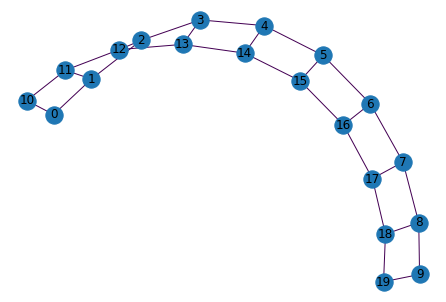

[[0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]]


In [10]:
#produce the MRF
G = nx.ladder_graph(10)
n = G.number_of_nodes()
draw_graph(G=G)
#mask is the adjacency pattern
mask = np.array(nx.adjacency_matrix(G).todense())
np.fill_diagonal(mask, 1.)
# populate the adjacency matrix (interaction values are positive and constant A_{ij} = 1)
adj = mask * 1 

#no local field for this experiment
np.fill_diagonal(adj, 0)
# make the matrix symmetric
zero_inds = np.tril_indices_from(adj,-1)
adj[zero_inds] = 0
adj += adj.T.copy()

print(adj)


We calculate the marginals using ```brute_force``` inference. Note that the marginals returned by the ```get_marginal()``` method, is $p(x_i = +1)$ for all $i \in target$, for a list/vector of target variables.
Below we plot the prior and posterior marginals after conditioning on $x_0 = -1$. If your implementation
of ```incorporate_evidence``` is correct, you should get the output below.
### 1.b. (2pts)
Why is the prior marginal uniform? How do you explain the pattern in the posterior marginal? 

In [4]:
#get the marginals for all the variables
bfi = BruteForceInference(adj, verbosity=2)
prior_m = bfi.get_marginal(list(range(0,n)))
bfi.incorporate_evidence({0:-1})
posterior_m = bfi.get_marginal(list(range(0,n)))

#plot the marginals
ind = np.arange(len(posterior_m))  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots()
m1 = ax.bar(ind, prior_m, width, color='r')
m2 = ax.bar(ind + width, posterior_m, width, color='b')
ax.legend((m1[0], m2[0]), ('prior marginals', 'posterior marginals'))    
plt.show()


producing the joint dist over 20 variables
producing the joint marginals over 20 targe variables
reducing the joint marginals to univar. marginals


NameError: name 'new_adj' is not defined

## Problem 2. Clique-Tree (20 pts)

In this problem you complete the implementation of clique-tree algorithm below.
When you initialize a clique-tree object, using ```cti = CliqueTreeInference(adj, verbosity=2)```,
the ```_build_clique_tree()``` method is called, which performs the following:

- triangulating the graph to get a chordal graph using min-fill method (plotted when ```verbosity > 1```)
- finding the maximal cliques in the chordal graph
- calculating the clique-potentials
- selecting the sepsets using max-spanning tree
- selecting a root node and building a directed tree. When you call ```get_marginal()```, it sends the message from the leaf nodes towards _a_ root and back to the leaf nodes.
If you set ```verbosity=2```, then you would also see the plot of the clique-tree, as well as the chordal graph.

### 2.a. (16 pts)
Implement ```_min_fill()``` method for triangulation (8 pts) and;  ```calc_clique_potentials()``` (8pts).
See the comments in the code for input/ouputs of each method.

In [5]:
class CliqueTreeInference(Inference):
    """
    implements exact inference using clique-tree
    """
    
    def __init__(self, adj,
                 verbosity=1,
                 #normalizing messages helps with overflow in large models,
                 normalize_messages=True, 
                 
    ):
        Inference.__init__(self, adj, verbosity=verbosity)
        self._normalize_messages = normalize_messages
        self.cliques = None  # a list of lists
        # a 0-1 matrix wehre ctree[i,j] > 0 means cliques[i] and cliques[j] are connected in the clique-tree
        self.ctree_adj = None
        self.chordal = None  # the 0-1 chordal graph
        self.order = None  # the elimination order
        # dictionary identifying the parent of each node in the ctree with root=0
        self.parents = None
        # dictionary identifying the children of each node in the ctree with root=0
        self.children = None
        # dictionary of messages sent from clique i->j (i,j):msg, where the variables in the sepset appear in their natural order in the msg tensor
        self.messages = {}
        # a list of tensors, corresponding to clique potentials (i.e., product of all factors associated with a clique)
        self.clique_potentials = None
        # a dict of tensors, corresponding to the marginal beliefs over cliques
        self.clique_beliefs = {}
        # indicates whether the message updates have been sent or not
        self._calibrated = False         
        # build the clique-tree from the adjacency matrix
        self._build_clique_tree()

        
    def update_adjacency(self, new_adj):
        self.adj = new_adj
        self.ctree_adj = None
        self.order = None
        self.chordal_adj = None
        self.messages = {}
        self.parents = None
        self.children = None
        self.cliques = None
        self.clique_potentials = None
        self.clique_beliefs = None
        self._build_clique_tree()
        self._calibrated = False
        
    def _min_fill(self):
        """
        return the elimination order (a list of indices) as well
        as the resulting chordal graph baded on min_fill huristic
        chordal_adj[i,j] = 1 iff (i,j) are connected. 
        The diagonal of chordal_adj should be zero.
        """
        adj = self.adj
        # >>>> YOUR CODE HERE >>>>>>>

        # >>>> YOUR CODE HERE >>>>>>>
        return order, chordal_adj
    
    def _max_cardinality_search(self, mask):
        """
        mask is the adjacency matrix for 0-1 chordal graph
        this method returns a list of lists: the set of maximal cliques
        we can also return sep-sets here, but we do that using max-spanning-tree later
        """
        n = mask.shape[0]
        cliques = [[]]  # maintains the list of cliques
        last_mark = -1  # number of marked neighbors for prev. node
        marks = [[] for i in range(n)]  # a set tracking the marked neighbors of each node
        mark_size = np.zeros(n)  # number of marked neighbors for each node
        remaining = list(range(n))
        for _ in reversed(range(n)):
            node = remaining[np.argmax(mark_size[remaining])]
            if mark_size[node] <= last_mark:  # moving into a new clique
                cliques.append(marks[node] + [node])
            else:  # add it to the last clique
                cliques[-1].append(node)
            nb_node = np.nonzero(mask[node,:])[0]  # neighbors of node
            for nb in nb_node:  # update the marks for neighbors
                marks[nb].append(node)
                mark_size[nb] += 1
            last_mark = mark_size[node]
            remaining.remove(node)
        sorted_cliques = [sorted(c) for c in cliques]
        return sorted_cliques
    
    def _get_directed_tree(self, adj, root=0):
        """
        produce a directed tree from the adjacency matrix, with the given root
        return a dictionary of children and parents for each node
        """
        visited = set()
        to_visit = set([0])
        n = adj.shape[0]
        rest = set(range(1, n))
        parents = {root:None}
        children = {}
        while len(to_visit) > 0:
            current = to_visit.pop()
            nexts = set(np.nonzero(adj[current, :])[0]).intersection(rest)
            for j in nexts:
                parents[j] = current
            children[current] = frozenset(nexts)
            to_visit.update(nexts)
            rest.difference_update(nexts)
            visited.add(current)
        assert len(rest) == 0, "the clique tree is disconnected!"
        return parents, children

    def _calc_clique_potentials(self, cliques):
        """
        Calculate the potential/factor for each clique
        as the product of factors associated with it.
        Note that each local and pairwise factor is counted within
        a single clique (family-preserving property).
        The method receives a list of lists of variable indices, that define the cliques.
        It should return a list of tensors. if cliques[2].ndim == 3, 
        then the clique_potentials[2]
        should be a 3-dimensional (2 x 2 x 2) tensor. 
        """
        adj = self.adj
        n = adj.shape[0]
        # >>>> YOUR CODE HERE >>>>>>>

        # >>>> YOUR CODE HERE >>>>>>>
        return clique_potentials

    def _build_clique_tree(self):
        """
        builds the clique-tree from the adjacency matrix by 
        1. triangulating the graph to get a chordal graph
        2. find the maximal cliques in the chordal graph
        3. calculating the clique-potentials
        4. selecting the sepsets using max-spanning tree
        5. selecting a root node and building a directed tree
        this method does not calibrate the tree -- i.e., it doesn't 
        send the messages upward and downward in the tree
        """
        if self._verbosity > 0:
            print("building the clique-tree ...", flush=True)
        order, chordal_adj = self._min_fill()
        if self._verbosity > 1:
            print("\t found the elimination order {}".format(order), flush=True)
            chordal_viz = chordal_adj + (self.adj != 0)  # so that the color of the chords is different
            np.fill_diagonal(chordal_viz, 0)
            draw_graph(chordal_viz, draw_edge_color = True, title="chordal graph")
        cliques = self._max_cardinality_search(chordal_adj)
        if self._verbosity > 1:
            print("\t number of maximal cliques: {} with max. size: {}".format(len(cliques),
                max([len(c) for c in cliques])), flush=True)
            labels = [[c for c in range(len(cliques)) if i in cliques[c]] for i in range(self.adj.shape[0])]
            draw_graph(chordal_viz, draw_edge_color = True, node_labels= labels)
        if self._verbosity > 1:
            print("\t calculating clique potentials")
        # assign each factor (pairwise or local) to a clique and calculate the clique-potentials
        clique_potentials = self._calc_clique_potentials(cliques)
        # find the size of septsets between all cliques and use max-spanning tree to build the clique-tree
        sepset_size = np.zeros((len(cliques), len(cliques)))
        for i, cl1 in enumerate(cliques):
            for j, cl2 in enumerate(cliques):
                if i != j:
                    sepset_size[i, j] = max(len(set(cl1).intersection(cl2)), .1)
        if self._verbosity > 1:
            print("\t finding the max-spanning tree", flush=True)
        # use scipy for max-spanning-tree
        ctree = minimum_spanning_tree(
            csr_matrix(-sepset_size)).toarray().astype(int)
        # make it symmetric
        ctree_adj = (np.maximum(-np.transpose(ctree.copy()), -ctree) > 0)
        if self._verbosity > 1:
            draw_graph(ctree_adj, title="clique-tree", node_size=600, node_labels=cliques)            
        # set the first cluster to be the root and build the directed tree
        root = 0
        parents, children = self._get_directed_tree(ctree_adj, root)
        self.parents = parents
        self.children = children
        self.chordal_adj = chordal_adj
        self.cliques = cliques
        self.ctree_adj = ctree_adj
        self.clique_potentials = clique_potentials
        if self._verbosity > 0:
            print("... done!", flush=True)

    def _calc_message(self,
                      src_node,  # source of the message
                      dst_set,  # a set of destinations,
                      upward,
    ):
        """
        if the downward, the message to all destinations is calculated by first 
        obtaining the belief and dividing out the corresponding incoming messages
        This assumes that the distribution is positive and therefore messages are never zero.
        during the upward pass there is only a single destination and the message is obtained directly
        should also work when the dst_set is empty (producing belief over the leaf nodes)
        """
        # incoming messages are from these clusters
        incoming = set(self.children[src_node])
        if self.parents[src_node] is not None:
            incoming.add(self.parents[src_node])
        if upward:
            incoming.difference_update(dst_set)  # only has one destination
            assert len(dst_set) == 1, "should have a single receiver in the upward pass!"
        factor = self.clique_potentials[src_node].copy()
        clique_vars = self.cliques[src_node]
        for r in incoming:
            sepset = list(set(self.cliques[r]).intersection(set(clique_vars)))
            # find the index of sepset in the clique potential
            inds = sorted([clique_vars.index(i) for i in sepset])
            # multiply with the incoming message from the child
            factor = tensor_mult(factor, self.messages[(r,src_node)], inds, list(range(len(sepset))))
        for dst_node in dst_set:
            tmp_factor = factor.copy()            
            if not upward:  # divide out the incoming message to produce the outgoing message
                sepset = set(self.cliques[dst_node]).intersection(set(clique_vars))
                # find the index of sepset in the clique potential
                inds = sorted([clique_vars.index(i) for i in sepset])
                # multiply with the incoming message from the child
                tmp_factor = tensor_mult(tmp_factor, 1./self.messages[(dst_node,src_node)], inds, list(range(len(sepset))))
            outgoing_vars = set(clique_vars).intersection(set(self.cliques[dst_node]))
            sum_over_vars = set(clique_vars) - set(outgoing_vars)
            sum_over_vars_inds = sorted([clique_vars.index(i) for i in sum_over_vars])
            msg = np.sum(tmp_factor, axis=tuple(sum_over_vars_inds))
            if self._normalize_messages:
                msg /= np.sum(msg)
            self.messages[(src_node,dst_node)] = msg
            if self._verbosity > 2:
                print("{} -> ({})-> {}".format(clique_vars, outgoing_vars ,self.cliques[dst_node]), flush=True)
        return factor  # is used to set the clique-marginals in the downward pass        

    def _upward(self, root=0):
        """
        send the message from leaf nodes towards the root
        each node sends its message as soon as received messages from its children
        """
        if self._verbosity > 0:
            print("sending messages towards the root node", end="", flush=True)
        # leaf nodes
        ready_to_send = set([node for node, kids in self.children.items() if len(kids) == 0])  
        #until root receives all its incoming messages
        while root not in ready_to_send:
            if self._verbosity > 0:
                print(".", end="", flush=True)                
            current = ready_to_send.pop()
            # send the message to the parent
            parent = self.parents[current]
            self._calc_message(current, {parent}, True)
            #if the parent has received all its incoming messages, add it to ready_to_send
            parent_is_ready = np.all([((ch,parent) in self.messages.keys()) for ch in self.children[parent]])
            if parent_is_ready: ready_to_send.add(parent)
        if self._verbosity > 0:
            print("", end="\n", flush=True)
        
    def _downward(self, root=0):
        """
        send the messages downward from the root
        each node sends its message to its children as soon as received messages from its parent
        """
        
        if self._verbosity > 0:
            print("sending messages towards the leaf nodes", end="", flush=True)
        ready_to_send = set([root])
        while len(ready_to_send) > 0:
            current = ready_to_send.pop()
            self.clique_beliefs[current] = self._calc_message(current, self.children[current], False)
            ready_to_send.update(self.children[current])
            if self._verbosity > 0:
                print(".", end="", flush=True)         
        if self._verbosity > 0:
            print("", end="\n", flush=True)          

    def get_marginal(self, target):
        """
        return the marginal prob. of xi = 1
        for the list of target variables
        --i.e., a vector of marginals p(xi=1)
        these are calculated using clique_beliefs
        """
        if not self._calibrated:
            self._upward()
            self._downward()
            self._calibrated = True
        
        if self._verbosity > 0:
            print("calculating the marginals for {} target variables".format(len(target)), flush=True)
        
        target_set = set(target)
        p1 = {}
        for c, clique in enumerate(self.cliques):
            cl_var_set = set(clique)
            for v in target_set.intersection(cl_var_set):
                v_ind = clique.index(v)
                summation_inds = list(set(range(len(cl_var_set))).difference({v_ind}))
                mrg = np.sum(self.clique_beliefs[c], axis=tuple(summation_inds))
                
                mrg /= np.sum(mrg)
                p1[v] = mrg[1]
        p1_arr = np.array([p1[v] for v in target])
        return p1_arr

If the min_fill method is correctly implemented, you should get the chordal graphs below for a ```cycle_graph```. It is important that you _debug_ your code using different family of graphs; see networkx graph-generators https://networkx.github.io/documentation/networkx-1.10/reference/generators.html

In [6]:
G = nx.cycle_graph(10)
mask = np.array(nx.adjacency_matrix(G).todense())
np.fill_diagonal(mask, 1.)
# populate the adjacency matrix (interaction values are positive and constant)
adj = mask * 1 
#no local field for this experiment
np.fill_diagonal(adj, 0)
# make the matrix symmetric
zero_inds = np.tril_indices_from(adj,-1)
adj[zero_inds] = 0
adj += adj.T.copy()
cti = CliqueTreeInference(adj, verbosity=2)


building the clique-tree ...


NameError: name 'order' is not defined

### 2.b. Comparing junction-tree algorithm with brute-force inference (4 pts)
In this part, write the code to compare the run-time of brute-force
inference and clique-tree in a graph of growing number of nodes (try increasing $n$ as much as your computer memory  permits). Plot _log_ inference-time versus number-of-variables for a __I__) ladder-graph and __II__) a complete graph.
Calculate the marginals over all variables, for both methods, when timing them. What is the tree-width of each model. How do you explain your observations? 

### Solution

#### Complete graph

#### ladder graph